In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

from spirals import make_spiral_random_radius, make_spiral_random_radius_confounder, plot_clusters, make_spiral_true_boundary
from armed.models.mlp_classifiers import BaseMLP, ClusterCovariateMLP, DomainAdversarialMLP, MixedEffectsMLPNonlinearSlope
from armed.models.metalearning import mldg
from armed.misc import expand_results_path, make_random_onehot

In [8]:
data = pd.read_csv(r'D:\Notes\Sem - 6\Thesis\Mixed Effect Model\Lit\datasets\breastcancercluster.csv', index_col = None)
data = data.drop('id',axis=1)
data = data.drop('Unnamed: 32',axis=1)
#data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [77]:
from sklearn import preprocessing
X = data.drop('diagnosis', axis=1).values
Y = data['diagnosis'].values
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2, random_state=42)
X = pca.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create a mapping dictionary for cluster labels
# Assuming 'M' corresponds to cluster 1 and 'B' corresponds to cluster 0
cluster_mapping = {'M': 1, 'B': 0}

# Create the one-hot encoded cluster membership (Z) array
Z = np.zeros((len(Y), 2))  # Assuming 2 clusters (M and B)

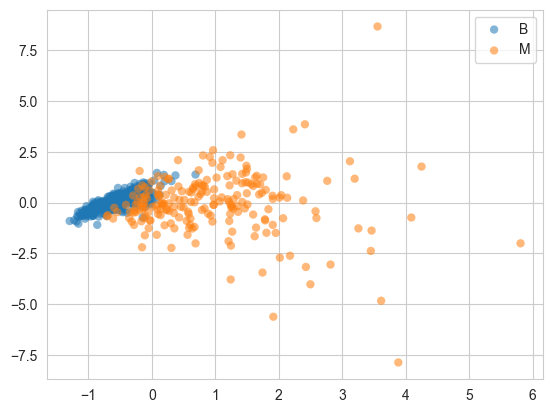

In [106]:
clusterB = X[Y == 0]
clusterM = X[Y == 1]

plt.scatter(clusterB[:, 0], clusterB[:, 1], label='B', alpha = 0.55, edgecolor = "None")
plt.scatter(clusterM[:, 0], clusterM[:, 1], label='M', alpha = 0.55, edgecolor = "None")
plt.legend()
plt.show()

In [80]:
# Convert the labels to their corresponding cluster indices
cluster_indices = [cluster_mapping[label] for label in Y]

In [81]:
# Set the corresponding cluster index to 1 in each row of Z
Z[np.arange(len(Z)), cluster_indices] = 1
Y = data['diagnosis'].map({'M':1,'B':0})

In [82]:
# Print the shapes of X, Y, and Z to verify the split
print("X :", X)
print("Y :", Y)
print("Z :", Z)

X : [[ 1.74304337 -3.44069213]
 [ 1.90677896  0.18297187]
 [ 1.4961195   0.45838127]
 ...
 [ 0.47251968  0.55667667]
 [ 1.69003062  0.39952755]
 [-1.15917313 -1.03768436]]
Y : 0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64
Z : [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# --------------------------------------------------------------------

# Trying out ARMED

In [129]:
def plot_clusters_here(X, Z, Y, random_effects=None, true_spiral_params=None):
    """Plot data points in each cluster.

    Args:
        X (array): independent variables
        Z (array): cluster membership design matrix
        Y (array): labels
        random_effects (array, optional): Cluster-specific random radii, 
            used to create the titles for each subplot. Defaults to None.
        true_spiral_params (dict, optional): Spiral parameters with keys 
            'classes' and 'degrees'. Defaults to None.

    Returns:
        figure, axes
    """    

    nClusters = Z.shape[1]
    nRows = 1 #int(np.ceil(nClusters / 5))

    #lsMarkers = ['o', 'P', 'X', 'D']    
    fig, ax = plt.subplots(1, 1, figsize = (3,3) , gridspec_kw={'hspace': 0.5})
    for iCluster in range(nClusters):       
        XCluster = X[Z[:, iCluster] == 1]
        YCluster = Y[Z[:, iCluster] == 1]

        iRow = iCluster // 2
        iCol = iCluster % 2

        #for iClass in range(Y.shape[1]):
        ax.scatter(XCluster[:,0], XCluster[:,1], c='r', s=1, alpha=0.55)

        if random_effects is not None:
            ax.set_title(f'Random effect: {random_effects[iCluster]:.03f}')
        if iCluster >= 1:
            ax.set_xlabel('Feature 1')
        if iCol == 0:
            ax.set_ylabel('Feature 2')

        if true_spiral_params:
            arrSpiralMid = make_spiral_true_boundary(true_spiral_params['classes'], 
                                                     true_spiral_params['degrees'], 
                                                     random_effects[iCluster])

            ax.plot(arrSpiralMid[:1000, 0], arrSpiralMid[:1000, 1], c='0.2', ls='--')
            ax.plot(arrSpiralMid[1000:, 0], arrSpiralMid[1000:, 1], c='0.2', ls='--')

        ax.set_xlim(X[:, 0].min(), X[:, 0].max())
        ax.set_ylim(X[:, 1].min(), X[:, 1].max())
        ax.set_aspect('equal')
        ax.set_aspect('equal')
    return fig, ax

<ipython-input-130-97c01ea18249>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figData.show()


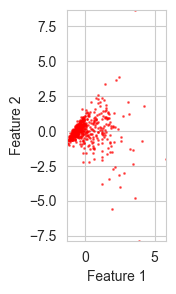

In [130]:
arrX = np.array(X)
arrY = np.array(Y)
arrZ = np.array(Z)
arrRadii = []

figData, axData = plot_clusters_here(arrX, arrZ, arrY)
figData.savefig(os.path.join(strOutputDir, 'spirals_data.png'))
figData.savefig(os.path.join(strOutputDir, 'spirals_data.svg'))
figData.show()

# One-hot to binary labels
# arrY = arrY[:, 1]

# Ensure float32
arrX = arrX.astype(np.float32)
arrY = arrY.astype(np.float32)
arrZ = arrZ.astype(np.float32)

# Use the class label and cluster membership in stratified k-fold partitioning later
arrStrata = [f'{y}_{z}' for y, z in zip(arrY, arrZ.argmax(axis=1))]
arrStrata = np.array(arrStrata)

In [131]:
#strOutputDir = expand_results_path(str(os.getcwd()), make=False)
strOutputDir = os.getcwd()

In [132]:
print(strOutputDir)

D:\Notes\Sem - 6\Thesis\Mixed Effect Model\ARMED\synthetic_dataset


In [133]:
dictSpiralParams = {'clusters': 10, 
                    'false_negatives': False, 
                    'confound_sd': 0.,
                    'radius_sd': 0.3,
                    'degrees': 360,
                    'confounded_vars': 0,
                    'noise': 0.1,
                    'random_seed': 48}

<ipython-input-138-a577e745f575>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figData.show()


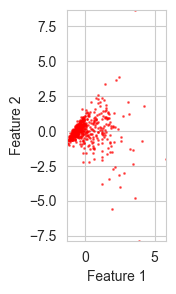

In [138]:
# Create dataset
np.random.seed(dictSpiralParams['random_seed'])
if dictSpiralParams['confound_sd'] > 0:
    arrX, arrZ, arrY, arrRadii, arrRatio = make_spiral_random_radius_confounder(dictSpiralParams['clusters'],
                                                                                mean_radius=0 if dictSpiralParams['false_negatives'] else 1,
                                                                                ratio_sd=dictSpiralParams['confound_sd'],
                                                                                radius_sd=dictSpiralParams['radius_sd'],
                                                                                degrees=dictSpiralParams['degrees'],
                                                                                confounders=dictSpiralParams['confounded_vars'],
                                                                                noise=dictSpiralParams['noise'])
else:    
    arrX, arrZ, arrY, arrRadii = make_spiral_random_radius(dictSpiralParams['clusters'], 
                                                        mean_radius=0 if dictSpiralParams['false_negatives'] else 1, 
                                                        inter_cluster_sd=dictSpiralParams['radius_sd'], 
                                                        degrees=dictSpiralParams['degrees'],
                                                        noise=dictSpiralParams['noise'])

arrX = np.array(X)
arrY = np.array(Y)
arrZ = np.array(Z)

figData, axData = plot_clusters_here(arrX, arrZ, arrY)
figData.savefig(os.path.join(strOutputDir, 'spirals_data.png'))
figData.savefig(os.path.join(strOutputDir, 'spirals_data.svg'))
figData.show()

# One-hot to binary labels
# arrY = arrY[:, 1]

# Ensure float32
arrX = arrX.astype(np.float32)
arrY = arrY.astype(np.float32)
arrZ = arrZ.astype(np.float32)

# Use the class label and cluster membership in stratified k-fold partitioning later
arrStrata = [f'{y}_{z}' for y, z in zip(arrY, arrZ.argmax(axis=1))]
arrStrata = np.array(arrStrata)

In [134]:
# create informative names for the confounded probe features
lsFeatureNames = ['1', '2'] 
if dictSpiralParams['confounded_vars'] > 0:
    lsFeatureNames += [f'Probe {i+1}' for i in range(dictSpiralParams['confounded_vars'])]

In [135]:
lsFeatureNames

['1', '2']

In [153]:
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=lsFeatureNames)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    nFeatures = 2 + dictSpiralParams['confounded_vars']
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': lsFeatureNames, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Cluster-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Cluster': range(nClusters), 'Random intercept': arrRandomInt})


def plot_percluster_decision_boundary(model, X, Y, Z, cluster_input=False, vmax=1.5, degrees=360, radii=None):
    """Plot decision boundaries learned per cluster. Currently only works with 2-class problems.

    Args:
        model (tf.keras.Model): trained model
        X (np.array): input
        Y (np.array): target
        Z (np.array): cluster membership matrix
        cluster_input (bool, optional): Whether model takes a cluster membership input. Defaults to False.
        vmax (float, optional): Extent of feature space to plot. Defaults to 1.5.
        degrees (int, optional): Spiral length (to plot true decision boundary). Defaults to 360.
        radii (array, optional): Cluster-specific radii (to plot true decision boundary). Defaults to None.

    Returns:
        figure, axes
    """    
    
    nClusters = Z.shape[1]
    nAxRows = 1
    fig, axes = plt.subplots(nAxRows, 2, figsize=(16, 3 * nAxRows), gridspec_kw={'hspace': 0.5})
    
    for iCluster in range(nClusters):
        ax = axes.flatten()[iCluster]
        
        arrXCluster = X[Z[:, iCluster]==1]
        arrYCluster = Y[Z[:, iCluster]==1]
        arrZCluster = Z[Z[:, iCluster]==1]
        
#         # Create grid of points in feature space
#         arrGridX1, arrGridX2 = np.mgrid[-vmax:vmax+0.1:0.01, -vmax:vmax+0.1:0.01]
#         # Fill in extra confounded features with 0.5
#         if X.shape[1] > 2:
#             arrGridX3 = np.ones_like(arrGridX1) * 0.5
#             arrGridXConf = np.stack([arrGridX3.flatten()] * (X.shape[1] - 2), axis=-1)
#             arrGridX = np.concatenate([arrGridX1.reshape(-1, 1), arrGridX2.reshape(-1, 1), arrGridXConf], axis=1)
#         else:    
#             arrGridX = np.stack([arrGridX1.flatten(), arrGridX2.flatten()], axis=0).T
            
#         if cluster_input:
#             arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
#             arrGridZ[:, iCluster] = 1
#             arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
#         else:
#             arrGridYFlat = model.predict(arrGridX, verbose=0) 
        
#         if isinstance(arrGridYFlat, tuple):
#             arrGridYFlat = arrGridYFlat[0]
#         arrGridY = (arrGridYFlat >= 0.5).reshape(arrGridX1.shape).astype(int)
        
#         # Use contour function to visualize decision boundary
#         ax.contour(arrGridX1, arrGridX2, arrGridY, levels=1, colors='k')  
#         ax.contourf(arrGridX1, arrGridX2, arrGridY, levels=1, colors=['C0', 'C1'], alpha=0.5)    
        
        # Plot data points
        ax.scatter(arrXCluster[arrYCluster == 0, 0], arrXCluster[arrYCluster == 0, 1], 
                   c='C0', s=5, alpha=0.9)
        ax.scatter(arrXCluster[arrYCluster == 1, 0], arrXCluster[arrYCluster == 1, 1], 
                   c='C1', s=10, alpha=0.9, marker='P')
        
#         if radii is not None:
#             # Plot true decision boundary (midpoint between classes)
#             arrTrueBoundary = make_spiral_true_boundary(degrees=degrees-180, 
#                                                         radius=radii[iCluster])
#             ax.plot(arrTrueBoundary[:1000, 0], 
#                                         arrTrueBoundary[:1000, 1], 
#                                         c='g', ls='--', lw=3)   
#             ax.plot(arrTrueBoundary[1000:, 0], 
#                                         arrTrueBoundary[1000:, 1], 
#                                         c='g', ls='--', lw=3)
                
        # Include accuracy in subplot title    
        if cluster_input:
            acc = model.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0, return_dict=True)['acc']
        else:
            acc = model.evaluate(arrXCluster, arrYCluster, verbose=0, return_dict=True)['acc']
        ax.set_title(f'Accuracy: {acc}')
        
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(-vmax, vmax)
        ax.set_aspect('equal')    
    return fig, axes
    

def cross_validate(model_class, use_z=False, build_args={}, compile_args={}, use_mldg=False, randomize_z=False):
    """Perform 10-fold cross-validation and return per-fold performance, feature importance, and decision boundary plot.

    Args:
        model_class: model class
        use_z (bool, optional): Whether model takes Z input. Defaults to False.
        build_args (dict, optional): Model build arguments. Defaults to {}.
        compile_args (dict, optional): Model compile arguments. Defaults to {}.
        use_mldg (bool, optional): Whether to use meta-learning domain generalization to train. Defaults to False.
        randomize_z (bool, optional): Randomize the Z input when evaluating on test data 
            (ablating the RE information). Defaults to False.

    Returns:
        if model_class == MixedEffectsMLPNonlinearSlope:
            performance, feature importance, random slope variance, random intercepts, decision boundary fig
        else: 
        performance, feature importance, decision boundary fig
    """    
    kfolds = StratifiedKFold(10)
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLPNonlinearSlope:
        lsRandomSlopeSD = [] 
        lsRandomInt = []
    
    for arrTrainIdx, arrTestIdx in kfolds.split(arrX, arrStrata):
        arrXTrain = arrX[arrTrainIdx,]
        arrYTrain = arrY[arrTrainIdx,]
        arrZTrain = arrZ[arrTrainIdx,]
        arrXTest = arrX[arrTestIdx,]
        arrYTest = arrY[arrTestIdx,]
        arrZTest = arrZ[arrTestIdx,]
        
        tf.random.set_seed(283)
        model = model_class(**build_args)
        
        if randomize_z:
            arrZTest = make_random_onehot(arrXTest.shape[0], arrZTrain.shape[1])
        
        if use_z:
            dataTrain = (arrXTrain, arrZTrain)
            dataTest = (arrXTest, arrZTest)
            # dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = arrXTrain
            dataTest = arrXTest     
            # dataHeldout = xHeldout
            
        model.compile(**compile_args)
        
        if use_mldg:
            # Call model once to instantiate weights
            _ = model.predict(arrXTrain, steps=1)
            model = mldg(arrXTrain, arrYTrain, arrZTrain, model, epochs=10, loss_fn=tf.keras.losses.binary_crossentropy)
        else:
            log = model.fit(dataTrain, arrYTrain,
                            validation_data=(dataTest, arrYTest),
                            epochs=10,
                            verbose=0)
            
        dictMetrics = {'Accuracy': model.evaluate(dataTrain, arrYTrain, verbose=0, return_dict=True)['acc'],
                       'Test Accuracy': model.evaluate(dataTest, arrYTest, verbose=0, return_dict=True)['acc']}
            
        lsResults += [dictMetrics]
        lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLPNonlinearSlope:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
    
    figDB, axDB = plot_percluster_decision_boundary(model, arrXTest, arrYTest, arrZTest, cluster_input=use_z,
                                                vmax=arrXTest.max(), degrees=dictSpiralParams['degrees'],
                                                radii=arrRadii)
    
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
    
    if model_class == MixedEffectsMLPNonlinearSlope:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept, figDB
    else:
        return dfResults, dfGrads, figDB
    
def compute_95ci(dfResults):
    print('Mean')
    print(dfResults.mean())
    
    print('95CI low') 
    print(dfResults.mean() - 1.96 * (dfResults.std() / (10**0.5)))

    print('95CI high') 
    print(dfResults.mean() + 1.96 * (dfResults.std() / (10**0.5)))

## Conventional MLP

<ipython-input-149-eb24d8bbbb73>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figDBBase.show()
<ipython-input-149-eb24d8bbbb73>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figGradsBase.show()


Mean
Accuracy         0.857690
Test Accuracy    0.853728
dtype: float64
95CI low
Accuracy         0.781754
Test Accuracy    0.778066
dtype: float64
95CI high
Accuracy         0.933626
Test Accuracy    0.929390
dtype: float64


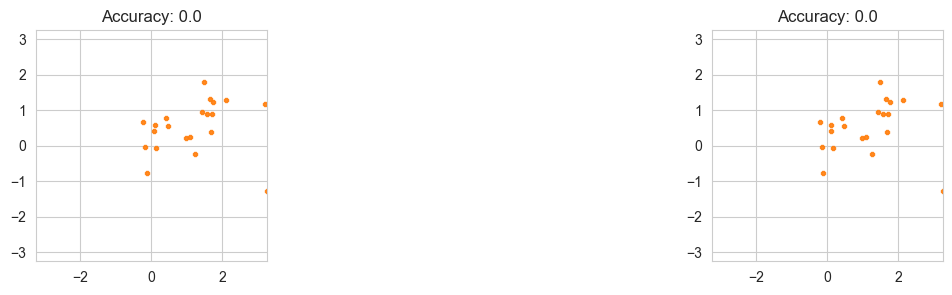

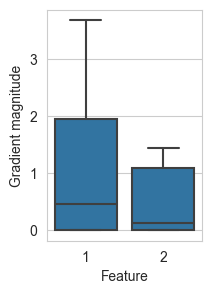

In [149]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.1)}
dfResultsBase, dfGradsBase, figDBBase = cross_validate(BaseMLP, compile_args=dictCompile)

# figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.png'))
# figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.svg'))
figDBBase.show()

figGradsBase, axGradsBase = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsBase, x='Feature', y='Gradient', ax=axGradsBase, color='C0')
axGradsBase.set_ylabel('Gradient magnitude')
# figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.png'))
# figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.svg'))
figGradsBase.show()

compute_95ci(dfResultsBase)

## Conventional MLP with additional cluster membership input

The data X and cluster membership matrix Z are simply concatenated together.

OperatorNotAllowedInGraphError: in user code:

    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    D:\Notes\Sem - 6\Thesis\Mixed Effect Model\ARMED\synthetic_dataset\armed\models\mlp_classifiers.py:35 call  *
        x, z = inputs
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\framework\ops.py:503 __iter__
        self._disallow_iteration()
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\framework\ops.py:496 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\framework\ops.py:472 _disallow_when_autograph_enabled
        raise errors.OperatorNotAllowedInGraphError(

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


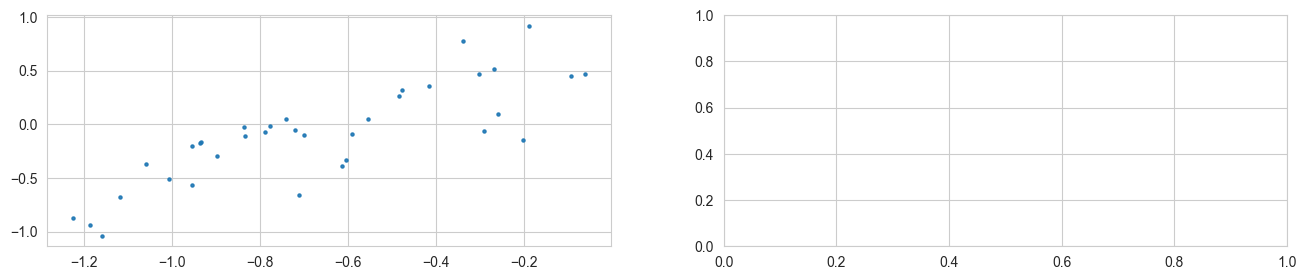

In [152]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
#dfResultsConcat = cross_validate(ClusterCovariateMLP, use_z=True, compile_args=dictCompile)
dfResultsConcat, dfGradsConcat, figDBConcat = cross_validate(ClusterCovariateMLP, use_z=True, compile_args=dictCompile)

# figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.png'))
# figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.svg'))
figDBConcat.show()

# figGradsConcat, axGradsConcat = plt.subplots(figsize=(arrX.shape[1], 3))
# sns.boxplot(data=dfGradsConcat, x='Feature', y='Gradient', ax=axGradsConcat, color='C0')
# axGradsConcat.set_ylabel('Gradient magnitude')
# figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.png'))
# figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.svg'))
# figGradsConcat.show()

compute_95ci(dfResultsConcat)

## Domain adversarial MLP

In [151]:
dictBuild = {'n_clusters': dictSpiralParams['clusters'], 'adversary_layer_units': [4, 4]}
dictCompile = {'loss_gen_weight': 0.5,
               'metric_class': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}

# dfResultsDA = cross_validate(DomainAdversarialMLP, use_z=True, build_args=dictBuild, compile_args=dictCompile)

dfResultsDA, dfGradsDA, figDBDA = cross_validate(DomainAdversarialMLP, use_z=True, 
                                                 build_args=dictBuild, compile_args=dictCompile)
# figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.png'))
# figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.svg'))
figDBDA.show()

# figGradsDA, axGradsDA = plt.subplots(figsize=(arrX.shape[1], 3))
# sns.boxplot(data=dfGradsDA, x='Feature', y='Gradient', ax=axGradsDA, color='C0')
# axGradsDA.set_ylabel('Gradient magnitude')
# figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.png'))
# figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.svg'))
# figGradsDA.show()

compute_95ci(dfResultsDA)

ValueError: in user code:

    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    D:\Notes\Sem - 6\Thesis\Mixed Effect Model\ARMED\synthetic_dataset\armed\models\mlp_classifiers.py:216 train_step
        loss_adv = self.loss_adv(clusters, pred_cluster, sample_weight=sample_weights)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 2) and (32, 10) are incompatible


## Mixed effects MLP 
With nonlinear slope layer

In [216]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 1.0, 
               'loss_gen_weight': 0.5, 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept, figDBME = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)
# figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.png'))
# figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.svg'))
figDBME.show()

# figGradsME, axGradsME = plt.subplots(figsize=(arrX.shape[1], 3))
# sns.boxplot(data=dfGradsME, x='Feature', y='Gradient', ax=axGradsME, color='C0')
# axGradsME.set_ylabel('Gradient magnitude')
# figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.png'))
# figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.svg'))
# figGradsME.show()

compute_95ci(dfResultsME)

ValueError: in user code:

    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    D:\Notes\Sem - 6\Thesis\Mixed Effect Model\ARMED\synthetic_dataset\armed\models\mlp_classifiers.py:473 train_step
        loss_adv = self.loss_adv(clusters, pred_cluster, sample_weight=sample_weights)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\htals\.conda\envs\armedconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 2) and (32, 10) are incompatible
